## Load the data

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Load the data that I have cleaned in the notebook 'Data cleaning and EDA'
jobs = pd.read_csv('./data/jobs_with_salary_cleaned.csv')
jobs.head()

,Unnamed: 0,job_id,job_title,recruiter,posted_date,city,job_type,classification,suburb,subclassification,recruiter_rating,description,salary_num
0,0,40925581,Data Engineer,The Onset,2020-02-10,Sydney,Full Time,Information & Communication Technology,"CBD, Inner West & Eastern Suburbs",Engineering - Software,NaN,It's your call whether to garner support from ...,170000.0
1,1,40924597,Data Engineer,Precision Sourcing,2020-02-10,Sydney,Full Time,Information & Communication Technology,NaN,Developers/Programmers,NaN,About the business This is an amazing time to...,115000.0
2,2,40912608,Data Engineer,Hays Information Technology,2020-02-07,Sydney,Full Time,Information & Communication Technology,"CBD, Inner West & Eastern Suburbs",Developers/Programmers,NaN,Data Engineer Your new company A national ban...,110000.0
3,3,40872824,Senior Data Engineer (Spark/Python/PySpark) | ...,Naviro,2020-02-03,Sydney,Contract/Temp,Information & Communication Technology,"CBD, Inner West & Eastern Suburbs",Engineering - Software,NaN,Unique opportunity for a Senior Data Engineer ...,200000.0
4,4,40890583,Data Engineer,eHealth NSW,2020-02-05,Sydney,Full Time,Information & Communication Technology,North Shore & Northern Beaches,Engineering - Software,3.1,Partnering with health agencies and industry t...,121696.5


In [3]:
# Drop the unexpected 'Unnamed: 0' column
jobs.drop('Unnamed: 0', axis=1, inplace=True)
jobs.shape

(1725, 12)

In [4]:
# Check dtype of all columns
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1725 entries, 0 to 1724
Data columns (total 12 columns):
job_id               1725 non-null int64
job_title            1725 non-null object
recruiter            1725 non-null object
posted_date          1725 non-null object
city                 1725 non-null object
job_type             1725 non-null object
classification       1725 non-null object
suburb               1251 non-null object
subclassification    1725 non-null object
recruiter_rating     274 non-null float64
description          1725 non-null object
salary_num           1725 non-null float64
dtypes: float64(2), int64(1), object(9)
memory usage: 161.8+ KB


In [5]:
# Convert 'posted_date' to timestamp type
jobs['posted_date'] = pd.to_datetime(jobs['posted_date'])

In [6]:
# Check number of unique values for each columns
for col in jobs.columns:
    print(col, ':', len(jobs[col].unique()))

job_id : 1725
job_title : 1304
recruiter : 652
posted_date : 36
city : 11
job_type : 4
classification : 28
suburb : 21
subclassification : 176
recruiter_rating : 21
description : 1558
salary_num : 384


## Preprocess data with NLP

###### Use NLP to convert 'job_title' and 'description' columns into features 

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer,make_column_transformer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [8]:
# Preprocessing strategy:

# -The following features will be preprocessed for modeling:
# 'city', 'job_type', 'classification', 'suburb','job_title','description','recruiter_rating'

# -The following features are considered irrelevant therefore will be excluded from the dataset:
# 'job_id', 'posted_date', 'recruiter', 'subclassification'

# -The following variable will be the target variable y: 'salary_num'

In [9]:
# Firstly, use SimpleImputer to fill up all the nan values in the dataset

from sklearn.impute import SimpleImputer

fill_missing = make_column_transformer((SimpleImputer(strategy='constant',fill_value='missing'),['city']),
                          (SimpleImputer(strategy='constant',fill_value='missing'),['job_type']),
                          (SimpleImputer(strategy='constant',fill_value='missing'),['classification']),
                          (SimpleImputer(strategy='constant',fill_value='missing'),['suburb']),
                          (SimpleImputer(strategy='constant',fill_value='missing'),['job_title']),
                          (SimpleImputer(strategy='constant',fill_value='missing'),['description']),
                          (SimpleImputer(strategy='median'),['recruiter_rating']),
                         remainder='drop')          

In [10]:
# Then, use the following strategies to preprocess the categorical columns:
# -Encode 'city', 'job_type', 'classification', 'suburb'.
# -CountVectorizer 'job_title'.
# -TfidfVectorizer 'description'.
# -Drop the remaining features by remainder='drop'.(If 'passthrough', will get problem with getting feature names later)

features_creator = ColumnTransformer([('city_category', OneHotEncoder(dtype='int', handle_unknown='ignore'),[0]),
                          ('job_type_category', OneHotEncoder(dtype='int', handle_unknown='ignore'),[1]),
                          ('classification_category', OneHotEncoder(dtype='int', handle_unknown='ignore'),[2]),
                          ('suburb_category', OneHotEncoder(dtype='int', handle_unknown='ignore'),[3]),
                          ('job_title_category', CountVectorizer(stop_words='english'),4),
                          ('description_tfidf', TfidfVectorizer(stop_words='english', sublinear_tf=True), 5)],
                         remainder='drop')
# -Use column index instead of column names in the process because the column names have been removed in fill_missing

In [12]:
# Make a pipeline that combine the processes of fill_missing and features_creator
from sklearn.pipeline import make_pipeline

transformer = make_pipeline(fill_missing,features_creator)

In [13]:
# Use the pipeline to process the data
data = transformer.fit_transform(jobs)

In [14]:
# Check the type and shape of the data
data

<1725x20983 sparse matrix of type '<class 'numpy.float64'>'
	with 289565 stored elements in Compressed Sparse Row format>

## Reduct feature dimensions with PCA

In [15]:
# After processing the data, now I got 20983 features which is too many. 
# The next step is to reduct feature dimensions so that the data is more suitable for modeling 

In [16]:
from sklearn.decomposition import PCA,SparsePCA,TruncatedSVD

In [17]:
# Choose TruncatedSVD as compare to PCA it is more effective to deal with sparse matrix

tsvd_100=TruncatedSVD(n_components=100)
tsvd_100.fit_transform(data)

array([[ 1.9847561 , -0.59347215, -0.39300521, ...,  0.00603305,
        -0.02720213,  0.0201746 ],
       [ 1.85454638,  0.1225187 , -0.08355663, ..., -0.00255045,
        -0.05290021,  0.01431173],
       [ 1.98719544, -0.59183089, -0.38965552, ..., -0.01163633,
        -0.03368972,  0.03449365],
       ...,
       [ 0.88043726,  0.83209067,  0.95105551, ..., -0.06272621,
         0.06838095, -0.03435143],
       [ 1.32149358, -0.68239278, -0.68184011, ..., -0.02552094,
         0.04957053,  0.32556797],
       [ 1.39836459, -0.88171485,  0.6293769 , ..., -0.122046  ,
        -0.06115909,  0.0362974 ]])

In [18]:
tsvd_100.explained_variance_

array([0.18014697, 0.49855518, 0.4191677 , 0.31860701, 0.29482421,
       0.17397365, 0.1710216 , 0.1478113 , 0.14473202, 0.13707359,
       0.11617205, 0.09027131, 0.08684804, 0.07646414, 0.07286658,
       0.06821168, 0.06712696, 0.06303613, 0.05611708, 0.054337  ,
       0.05115897, 0.04629557, 0.04327554, 0.04282825, 0.04148043,
       0.04083684, 0.03955282, 0.03822125, 0.03433752, 0.03392903,
       0.03325176, 0.03258368, 0.03142186, 0.03103429, 0.02985353,
       0.02964253, 0.02830745, 0.02789712, 0.02746839, 0.02696497,
       0.02601763, 0.02571367, 0.02504341, 0.02487908, 0.02460833,
       0.02373521, 0.02301395, 0.02273413, 0.02234927, 0.02187448,
       0.02118127, 0.02097198, 0.02056239, 0.02006134, 0.01946189,
       0.01903518, 0.01880224, 0.01860198, 0.01819061, 0.01780535,
       0.01761775, 0.0174544 , 0.01683382, 0.01661112, 0.01636109,
       0.01608746, 0.01594697, 0.01580404, 0.01556602, 0.01535774,
       0.01521735, 0.01507911, 0.01493964, 0.01468068, 0.01453

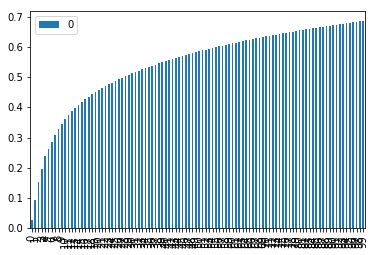

In [19]:
pd.DataFrame(tsvd_100.explained_variance_ratio_).cumsum().plot.bar()

In [20]:
tsvd_150=TruncatedSVD(n_components=150)
tsvd_150.fit_transform(data)

array([[ 1.9847561 , -0.59347215, -0.39300521, ..., -0.01036444,
        -0.00960266, -0.01894986],
       [ 1.85454638,  0.1225187 , -0.08355663, ..., -0.08493821,
        -0.01383767, -0.03332987],
       [ 1.98719544, -0.59183089, -0.38965552, ..., -0.01893114,
        -0.01276205, -0.02466605],
       ...,
       [ 0.88043726,  0.83209067,  0.95105551, ..., -0.13863282,
        -0.17536587,  0.09774425],
       [ 1.32149358, -0.68239278, -0.68184011, ..., -0.24795567,
         0.22400343, -0.13108202],
       [ 1.39836459, -0.88171485,  0.6293769 , ...,  0.00716827,
        -0.03532913,  0.01907058]])

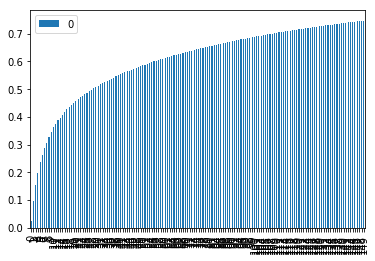

In [21]:
pd.DataFrame(tsvd_150.explained_variance_ratio_).cumsum().plot.bar()

In [22]:
# Base on the plots above, the first 100 components of the data represent 70% of the total variance, and the first 150
# components represent 75% of the total variance. As adding 50 more components only increased explained_variance_ratio
# by around 5%, I am happy with using n_components=100 to preprocess the data.

## Modeling - Predict Salary

### 1. Predict salary amount via regression model

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [24]:
y = jobs['salary_num'].values
X = tsvd_100.fit_transform(data)

In [25]:
# Calculate the baseline (Baselien is the RMSE when predicted salary equals the median of the actual salary)

import math
from sklearn.metrics import mean_squared_error

y_predict = np.median(y)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

print('Baseline RMSE:', rmse(y_predict, y))

Baseline RMSE: 44332.6147223689


In [26]:
# Fit a linear model and get the cross validation scores
lr = LinearRegression()
scores = cross_val_score(lr, X, y, cv=10,)
print('Cross validation scores:', scores)
print('Mean score:', np.mean(scores))

Cross validation scores: [-0.0212484   0.25970951  0.41658084  0.18211571  0.46964132  0.41106296
  0.28047405  0.53630592  0.19260513  0.12192493]
Mean score: 0.2849171964835515


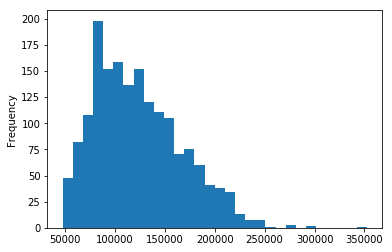

In [28]:
# Check distribution of y
jobs['salary_num'].plot.hist(bins=30)

In [29]:
# The distribution of target y is right skewed. 
# Transform the target y to make it normally distributed before fit the model

from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp)
scores = cross_val_score(model, X, y, cv=10)
print('Cross validation scores:', scores)
print('Mean score:', np.mean(scores))

Cross validation scores: [-0.18024315  0.28335301  0.4537081   0.19776833  0.49440308  0.39108953
  0.36386713  0.54056441  0.19842634  0.17668461]
Mean score: 0.29196213903085455


In [30]:
# Calculate the RMSE of the linear model
predictions = cross_val_predict(model, X, y, cv=10)
print('RMSE of the model:', rmse(predictions, y))

# According to the result, the Model's RMSE is smaller than baseline RMSE. It means the model performs well

RMSE of the model: 35217.37923834799


In [31]:
# Try some regularizing regression models to see if better performance can be achieved
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Ridge
model_Ridge = TransformedTargetRegressor(regressor=Ridge(), func=np.log, inverse_func=np.exp)
scores = cross_val_score(model_Ridge, X, y, cv=10)
print('Ridge Cross validation scores:', scores)
print('Ridge Mean score:', np.mean(scores))
print('---------------------------------------------------------------------------------------------------------')

# Lasso
model_Lasso = TransformedTargetRegressor(regressor=Lasso(), func=np.log, inverse_func=np.exp)
scores = cross_val_score(model_Lasso, X, y, cv=10)
print('Lasso Cross validation scores:', scores)
print('Lasso Mean score:', np.mean(scores))
print('---------------------------------------------------------------------------------------------------------')

# ElasticNet
model_ElasticNet = TransformedTargetRegressor(regressor=ElasticNet(), func=np.log, inverse_func=np.exp)
scores = cross_val_score(model_ElasticNet, X, y, cv=10)
print('ElasticNet Cross validation scores:', scores)
print('ElasticNet Mean score:', np.mean(scores))

Ridge Cross validation scores: [-0.13530201  0.31099123  0.45647975  0.20493643  0.49392677  0.3924651
  0.36932239  0.54296405  0.24801583  0.1930584 ]
Ridge Mean score: 0.30768579223836096
---------------------------------------------------------------------------------------------------------
Lasso Cross validation scores: [-7.14501884e-01 -9.59959694e-02 -6.64153411e-02 -1.28209061e-02
 -3.04331958e-04 -8.60149106e-02 -9.06235903e-04 -7.24387440e-02
 -8.66745319e-04 -5.51278167e-02]
Lasso Mean score: -0.11053928854770614
---------------------------------------------------------------------------------------------------------
ElasticNet Cross validation scores: [-7.14501884e-01 -9.59959694e-02 -6.64153411e-02 -1.28209061e-02
 -3.04331958e-04 -8.60149106e-02 -9.06235903e-04 -7.24387440e-02
 -8.66745319e-04 -5.51278167e-02]
ElasticNet Mean score: -0.11053928854770614


In [32]:
# Ridge model looks perform well. Calculate the RMSE of the Ridge model
pred_ridge = cross_val_predict(model_Ridge, X, y, cv=10)
print('RMSE of the Ridge model:', rmse(pred_ridge, y))

# According to r2_square and RMSE, Ridge model performs the best so far

RMSE of the Ridge model: 34853.317147804344


0.47954964047948045

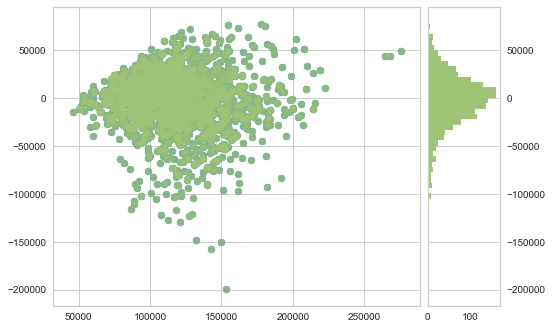

In [33]:
# Use ResidualsPlot to check if linear regression is suitable.
from yellowbrick.regressor import ResidualsPlot
ResidualsPlot(model_Ridge).fit(X,y).score(X,y)

# From the plot, the linear regression seems not very suitable for this dataset?

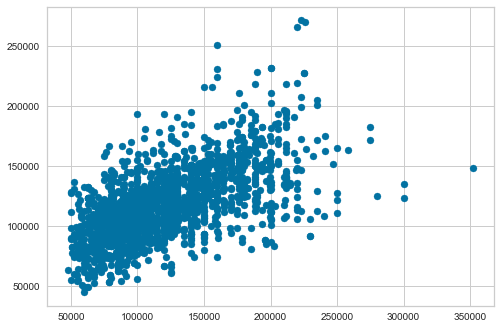

In [34]:
import matplotlib.pyplot as plt

plt.scatter(y, pred_ridge)

In [35]:
# From the scatter plot above, a linear relationship looks exist.
# Linear model is not perfect in this case, but to some extend we can still use it to predict salary

### 2. Classifiy 'high_pay' and 'low_pay' jobs via classification models

#### 2.1 Decision Tree (Feature Engineering - TruncatedSVD)

In [36]:
# Firstly, identify high pay and low pay
high_pay = []
for num in jobs['salary_num'].values:
    if num >= 115000: # distinguish the high or low pay by the median salary $115000
        high_pay.append('1')
    else:
        high_pay.append('0')

jobs['high_pay'] = [int(x) for x in high_pay]
jobs['high_pay'].value_counts()

1    904
0    821
Name: high_pay, dtype: int64

In [37]:
# Baseline accuracy
baseline_classifier = 904 / (904+821)
print('Baseline accuracy:', baseline_classifier)

Baseline accuracy: 0.5240579710144928


In [38]:
# Identify predictors X and the target y
yc = jobs['high_pay'].values
Xc = tsvd_100.fit_transform(data)

# Split the date into training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=0.2, random_state=0)

In [39]:
# Fit the model and predict
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
high_pay_pred = dtc.predict(X_test)

In [40]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, high_pay_pred)
conf_matrix

array([[104,  53],
       [ 51, 137]])

In [41]:
# Calculate the metrics for the classifier
total_population = conf_matrix.sum()
tp = conf_matrix[0][0]
fn = conf_matrix[0][1]
fp = conf_matrix[1][0]
tn = conf_matrix[1][1]

accuracy = (tp+tn) / total_population
print('Accuracy:', accuracy)

mis_class_rate = (fp+fn) / total_population
print('Misclassification_rate:', mis_class_rate)

recall = tp/ (tp+fn)
print('Recall/True Positive Rate:', recall)

fpr = fp / (tn + fp)
print('False Positive Rate:', fpr)

specificity = tn / (tn + fp)
print('True Negative Rate:', specificity)

precision = tp / (tp + fp)
print('Precision:', precision)

F1_score = 2 * (precision * recall) / (precision + recall)
print('F1 Score:', F1_score)

Accuracy: 0.6985507246376812
Misclassification_rate: 0.30144927536231886
Recall/True Positive Rate: 0.6624203821656051
False Positive Rate: 0.2712765957446808
True Negative Rate: 0.7287234042553191
Precision: 0.6709677419354839
F1 Score: 0.6666666666666666


In [42]:
# Check classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, high_pay_pred))

              precision    recall  f1-score   support

           0       0.67      0.66      0.67       157
           1       0.72      0.73      0.72       188

    accuracy                           0.70       345
   macro avg       0.70      0.70      0.70       345
weighted avg       0.70      0.70      0.70       345



In [43]:
# The classifier performs well as the accuracy is higher than baseline accuracy

#### 2.2 DecisionTree (Feature Engineering - SelectFpr)

In [44]:
from sklearn.feature_selection import SelectFpr,SelectFdr,chi2

preprocess_pipe = SelectFpr(score_func=chi2,alpha=0.01)

X_train, X_test, y_train, y_test = train_test_split(jobs, yc, test_size=0.2, random_state=0)

In [45]:
model_pipe= make_pipeline(transformer,preprocess_pipe,dtc)
model_pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('columntransformer-1',
                                  ColumnTransformer(n_jobs=None,
                                                    remainder='drop',
                                                    sparse_threshold=0.3,
                                                    transformer_weights=None,
                                                    transformers=[('simpleimputer-1',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 s

In [46]:
high_pay_pred2 = model_pipe.predict(X_test)

# Check classification report
print(classification_report(y_test, high_pay_pred2))

              precision    recall  f1-score   support

           0       0.70      0.69      0.70       157
           1       0.75      0.75      0.75       188

    accuracy                           0.72       345
   macro avg       0.72      0.72      0.72       345
weighted avg       0.72      0.72      0.72       345



In [47]:
# The model performs quite well

In [48]:
# Check what features are the most important for this model
import eli5
eli5.show_weights(model_pipe[-1],feature_names=np.array(model_pipe[0][1].get_feature_names())[model_pipe[1].get_support()])

Weight,Feature
0.1545,classification_category__x0_Information & Communication Technology
0.0857,job_title_category__senior
0.0639,job_type_category__x0_Contract/Temp
0.0636,"suburb_category__x0_CBD, Inner West & Eastern Suburbs"
0.0417,job_title_category__support
0.0346,job_title_category__engineer
0.0335,job_title_category__data
0.0256,job_title_category__research
0.0241,job_title_category__director
0.0230,city_category__x0_Adelaide


#### 2.3 Logistic Regression (Feature Engineering - VarianceThreshold)

In [49]:
from sklearn.feature_selection import VarianceThreshold, chi2, SelectKBest

In [50]:
# Use VarianceThreshold to filter the features, remove the features with low variance. 
features = make_pipeline(transformer,VarianceThreshold(0.005))
features.fit_transform(jobs)

<1725x176 sparse matrix of type '<class 'numpy.float64'>'
	with 11244 stored elements in Compressed Sparse Row format>

In [51]:
# Have a look at the features that after processing
np.array(features[0][1].get_feature_names())[features[1].get_support()]

array(['city_category__x0_ACT', 'city_category__x0_Adelaide',
       'city_category__x0_Brisbane', 'city_category__x0_Gold Coast',
       'city_category__x0_Melbourne',
       'city_category__x0_Newcastle, Maitland & Hunter',
       'city_category__x0_Other', 'city_category__x0_Perth',
       'city_category__x0_Sydney',
       'job_type_category__x0_Casual/Vacation',
       'job_type_category__x0_Contract/Temp',
       'job_type_category__x0_Full Time',
       'job_type_category__x0_Part Time',
       'classification_category__x0_Accounting',
       'classification_category__x0_Administration & Office Support',
       'classification_category__x0_Banking & Financial Services',
       'classification_category__x0_Construction',
       'classification_category__x0_Consulting & Strategy',
       'classification_category__x0_Education & Training',
       'classification_category__x0_Engineering',
       'classification_category__x0_Government & Defence',
       'classification_category__x0

In [52]:
from sklearn.linear_model import LogisticRegression

model_logistic=make_pipeline(features,LogisticRegression())
model_logistic.fit(jobs,yc)

/Users/carolcheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('pipeline',
                                  Pipeline(memory=None,
                                           steps=[('columntransformer-1',
                                                   ColumnTransformer(n_jobs=None,
                                                                     remainder='drop',
                                                                     sparse_threshold=0.3,
                                                                     transformer_weights=None,
                                                                     transformers=[('simpleimputer-1',
                                                                                    SimpleImputer(add_indicator=False,
                                                                                                  copy=True,
                                                

In [53]:
# Check what are the most important features for predicting high pay

eli5.show_weights(model_logistic[-1], feature_names=np.array(features[0][1].get_feature_names())[features[1].get_support()]
)

Weight?,Feature
+1.977,"classification_category__x0_Mining, Resources & Energy"
+1.865,job_title_category__head
+1.847,job_title_category__director
+1.785,job_title_category__architect
+1.590,job_title_category__principal
+1.425,job_title_category__team
+1.380,job_title_category__market
+1.361,job_title_category__senior
+1.352,job_title_category__mining
+1.310,classification_category__x0_Information & Communication Technology


In [54]:
# Identify predictors X and the target y
yc = jobs['high_pay'].values
Xl = features.fit_transform(jobs)

# Split the date into training set and test set
X_train, X_test, y_train, y_test = train_test_split(Xl, yc, test_size=0.2, random_state=0)

In [55]:
# Fit the model and predict
lgr = LogisticRegression()
lgr.fit(X_train,y_train)
high_pay_pred2 = lgr.predict(X_test)

/Users/carolcheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [56]:
# Check confusion_matrix
confusion_matrix(y_test, high_pay_pred2)

array([[110,  47],
       [ 31, 157]])

In [57]:
# Check classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, high_pay_pred2))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74       157
           1       0.77      0.84      0.80       188

    accuracy                           0.77       345
   macro avg       0.77      0.77      0.77       345
weighted avg       0.77      0.77      0.77       345



In [58]:
# The accuracy of the Logistic model is 77%. the model performs well.

## Modeling - Classify job categories

### 1. Distinguish Data Scientist and other job title

#### 1.1 Choose suitable dataset and clean data

In [59]:
# Add a column 'category_scientist', mark value as 1 if 'job_title' contain 'scientist', otherwise make as 0

list_scientist = []
for title in jobs['job_title'].values:
    job_title_text = [x.lower() for x in title.split()]
    if 'scientist' in job_title_text:
        list_scientist.append('1')
    else:
        list_scientist.append('0')

jobs['category_scientist'] = [int(x) for x in list_scientist]
jobs['category_scientist'].value_counts()

0    1699
1      26
Name: category_scientist, dtype: int64

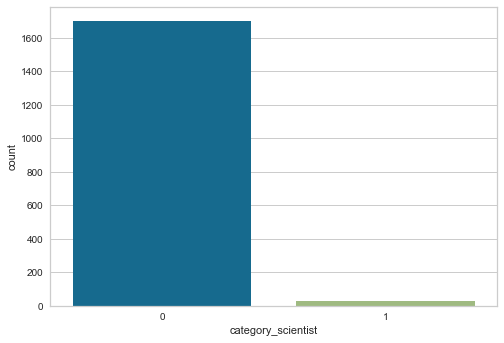

In [60]:
import seaborn as sns

sns.countplot(jobs['category_scientist'])

In [61]:
# As the data is very imbalance, I would use another dataset that includes all job postings no matter whether or not
# salary info is available.

# Load the data
jobs_all = pd.read_csv('./data/jobs_half_cleaned.csv')

# Check the dataframe
jobs_all.head(3)

,Unnamed: 0,job_id,job_title,recruiter,posted_date,city,job_type,classification,suburb,salary,subclassification,recruiter_rating,description
0,0,40771115,Python Expert,Atlastix,2020-01-19,Melbourne,Contract/Temp,Science & Technology,CBD & Inner Suburbs,NaN,"Mathematics, Statistics & Information Sciences",NaN,Are you a gun coder with a deep appreciation o...
1,1,40855053,Operations Command Center Engineer T2 - Data,The Vocus Group,2020-01-31,Melbourne,Full Time,Information & Communication Technology,CBD & Inner Suburbs,NaN,Telecommunications,2.8,"Do you love technology, network operations an..."
2,2,40925581,Data Engineer,The Onset,2020-02-10,Sydney,Full Time,Information & Communication Technology,"CBD, Inner West & Eastern Suburbs","$170,000 + Super + Bonus",Engineering - Software,NaN,It's your call whether to garner support from ...


In [62]:
# Drop the column 'Unnamed: 0' and 'salary'
jobs_all.drop(['Unnamed: 0','salary'], axis=1, inplace=True)

# Check the shape of the dataframe after dropping
jobs_all.shape

(7818, 11)

In [63]:
# subset the dataframe to narrow down the scope that 'job_title' contain 'data'
jobs_data = jobs_all[jobs_all['job_title'].str.lower().str.contains('data')]
jobs_data.shape

(1067, 11)

In [64]:
# subset the dataframe to narrow down the scope that 'job_title' contain 'scientist'
jobs_scientist = jobs_data[jobs_data['job_title'].str.lower().str.contains('scientist')]
jobs_scientist.shape

(86, 11)

In [65]:
# Add a column 'category_scientist', mark value as 1 if 'job_title' contain 'scientist', otherwise make as 0

list_scientist = []
for title in jobs_data['job_title'].values:
    job_title_text = [x.lower() for x in title.split()]
    if 'scientist' in job_title_text:
        list_scientist.append('1')
    else:
        list_scientist.append('0')

jobs_data['category_scientist'] = [int(x) for x in list_scientist]
jobs_data['category_scientist'].value_counts()

/Users/carolcheng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


0    985
1     82
Name: category_scientist, dtype: int64

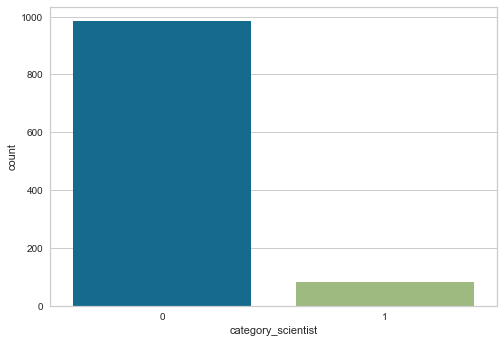

In [66]:
sns.countplot(jobs_data['category_scientist'])

In [67]:
# The data is still imbalance but better. The truth is that there are not many scientist jobs in the market.
# I am going to use the jobs_data dataset for the analysis(distinguish data scientist from other job title)

In [68]:
# Check the dataframe to see if any other cleaning job is required
jobs_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067 entries, 1 to 7806
Data columns (total 12 columns):
job_id                1067 non-null int64
job_title             1067 non-null object
recruiter             1067 non-null object
posted_date           1067 non-null object
city                  1067 non-null object
job_type              1067 non-null object
classification        1067 non-null object
suburb                718 non-null object
subclassification     1067 non-null object
recruiter_rating      292 non-null float64
description           1067 non-null object
category_scientist    1067 non-null int64
dtypes: float64(1), int64(2), object(9)
memory usage: 148.4+ KB


In [69]:
# Check number of unique values for each columns
for col in jobs_data.columns:
    print(col, ':', len(jobs_data[col].unique()))

job_id : 1067
job_title : 698
recruiter : 481
posted_date : 31
city : 10
job_type : 4
classification : 23
suburb : 20
subclassification : 81
recruiter_rating : 23
description : 977
category_scientist : 2


In [71]:
# The data looks cleaned. I am going to use it for preprocessing and modeling

#### 1.2 SVM model (Data Engineering: VarianceThreshold)

In [98]:
from sklearn import svm
clf = svm.SVC(kernel='linear')

In [99]:
# Identify the target y
ys = jobs_data['category_scientist'].values

# Split the date into training set and test set
X_train, X_test, y_train, y_test = train_test_split(jobs_data, ys, test_size=0.2, random_state=0)

In [100]:
# As our target 'category_scientist' is from job title, it is not reasonable to use 'job_title' as a feature 
# for the classification 

# Revise the features_creator to drop 'job_title' column
features_creator2 = ColumnTransformer([('city_category', OneHotEncoder(dtype='int', handle_unknown='ignore'),[0]),
                          ('job_type_category', OneHotEncoder(dtype='int', handle_unknown='ignore'),[1]),
                          ('classification_category', OneHotEncoder(dtype='int', handle_unknown='ignore'),[2]),
                          ('suburb_category', OneHotEncoder(dtype='int', handle_unknown='ignore'),[3]),
#                          ('job_title_category', CountVectorizer(stop_words='english'),4),
                          ('description_tfidf', TfidfVectorizer(stop_words='english', sublinear_tf=True), 5)],
                         remainder='drop')

# Revise preprocessing pipeline
transformer2 = make_pipeline(fill_missing, features_creator2)

In [101]:
# Use VarianceThreshold to filter the features, remove the features with low variance. 
model_svm = make_pipeline(transformer2, VarianceThreshold(0.008), clf)

In [102]:
# Fit the data with training set
model_svm.fit(X_train, y_train)

# Predict the target with test set
scientist_pred = model_svm.predict(X_test)

In [103]:
# Check classification report
print(classification_report(y_test, scientist_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       201
           1       0.75      0.23      0.35        13

    accuracy                           0.95       214
   macro avg       0.85      0.61      0.66       214
weighted avg       0.94      0.95      0.94       214



In [104]:
# Check what are the most important features for classifying scientist

eli5.show_weights(model_svm[-1],feature_names=np.array(model_svm[0][1].get_feature_names())[model_svm[1].get_support()])

Weight?,Feature
+2.000,classification_category__x0_Science & Technology
+1.000,job_type_category__x0_Contract/Temp
+1.000,job_type_category__x0_Full Time
+0.223,"suburb_category__x0_CBD, Inner & Western Suburbs"
+0.222,suburb_category__x0_CBD & Inner Suburbs
+0.222,suburb_category__x0_Eastern Suburbs
+0.222,suburb_category__x0_Bayside & South Eastern Suburbs
+0.222,suburb_category__x0_North Shore & Northern Beaches
+0.222,suburb_category__x0_missing
+0.222,"suburb_category__x0_CBD, Inner West & Eastern Suburbs"


### 2. Distinguish Senior and non Senior job title (SelectFpr + RandomForestClassifier)

In [85]:
# Add a column 'category_senior', mark value as 1 if 'job_title' contain 'senior', otherwise make as 0

list_senior = []
for title in jobs_data['job_title'].values:
    job_title_text = [x.lower() for x in title.split()]
    if 'senior' in job_title_text:
        list_senior.append('1')
    else:
        list_senior.append('0')

jobs_data['category_senior'] = [int(x) for x in list_senior]
jobs_data['category_senior'].value_counts()

/Users/carolcheng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


0    905
1    162
Name: category_senior, dtype: int64

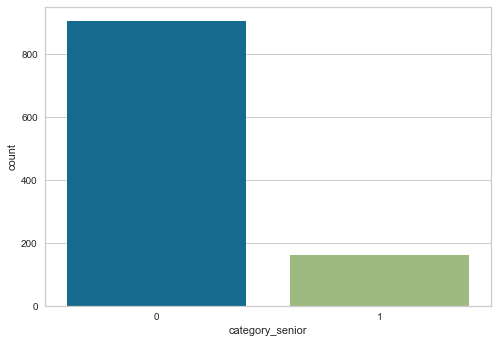

In [86]:
sns.countplot(jobs_data['category_senior'])

In [92]:
yr = jobs_data['category_senior'].values

X_train, X_test, y_train, y_test = train_test_split(jobs_data, yr, test_size=0.2, random_state=0)

In [93]:
# As our target 'category_senior' is from job title, it is not reasonable to use 'job_title' as a feature 
# for the classification 

# Revise the features_creator to drop 'job_title' column
features_creator2 = ColumnTransformer([('city_category', OneHotEncoder(dtype='int', handle_unknown='ignore'),[0]),
                          ('job_type_category', OneHotEncoder(dtype='int', handle_unknown='ignore'),[1]),
                          ('classification_category', OneHotEncoder(dtype='int', handle_unknown='ignore'),[2]),
                          ('suburb_category', OneHotEncoder(dtype='int', handle_unknown='ignore'),[3]),
#                          ('job_title_category', CountVectorizer(stop_words='english'),4),
                          ('description_tfidf', TfidfVectorizer(stop_words='english', sublinear_tf=True), 5)],
                         remainder='drop')

# Revise preprocessing pipeline
transformer2 = make_pipeline(fill_missing, features_creator2)

In [94]:
# Make pipeline for preprocessing and modeling
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

preprocess_pipe = SelectFpr(score_func=chi2,alpha=0.01)
rfc_pipe= make_pipeline(transformer2,preprocess_pipe, rfc)

In [95]:
# Fit the model
rfc_pipe.fit(X_train, y_train)

# Predict
senior_pred = rfc_pipe.predict(X_test)

/Users/carolcheng/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [96]:
# Check classification report
print(classification_report(y_test, senior_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       182
           1       0.64      0.50      0.56        32

    accuracy                           0.88       214
   macro avg       0.78      0.73      0.75       214
weighted avg       0.87      0.88      0.88       214



In [97]:
# Check what features are the most important for this model
import eli5
eli5.show_weights(rfc_pipe[-1],feature_names=np.array(rfc_pipe[0][1].get_feature_names())[rfc_pipe[1].get_support()])

Weight,Feature
0.9866 ± 0.0091,description_tfidf__senior
0.0134 ± 0.0091,city_category__x0_ACT
